<a href="https://colab.research.google.com/github/darthgera123/Object-Detection/blob/master/Detectron2_objde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OBJDE submission**
Team: [HARD_DRIVE_CORRUPTED](https://www.aicrowd.com/challenges/ai-blitz-5/teams/Hard_drive_corrupted)

### Install Pre-Built Detectron2

In [ ]:
!python3 -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html

### Import Libraries

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import torch, torchvision

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import itertools


### Dataset

The dataset consists of images of the 5 classes Person, Clothing, Car, Plant and Footwear. There are 40000 training and 4000 validation images. The CSV files containes the labels and bounding box(XMin, XMax, YMin and YMax) of images normalised between 0 and 1. There can be multiple objects in an image.

### Read csv files

In [ ]:
train_df = pd.read_csv("../input/object-det/train.csv")
val_df = pd.read_csv("../input/object-det/val.csv")

In [ ]:
# labels to number mapping
category_dict = {"Person":0, "Clothing":1, "Car":2, "Plant":3, "Footwear":4}

In [ ]:
train_df['category_id'] = train_df['LabelName'].apply(lambda x : category_dict[x])
train_df['image_category_id'] = train_df.groupby(['ImageID']).ngroup() 

val_df['category_id'] = val_df['LabelName'].apply(lambda x : category_dict[x])
val_df['image_category_id'] = val_df.groupby(['ImageID']).ngroup()

### Data visualisation

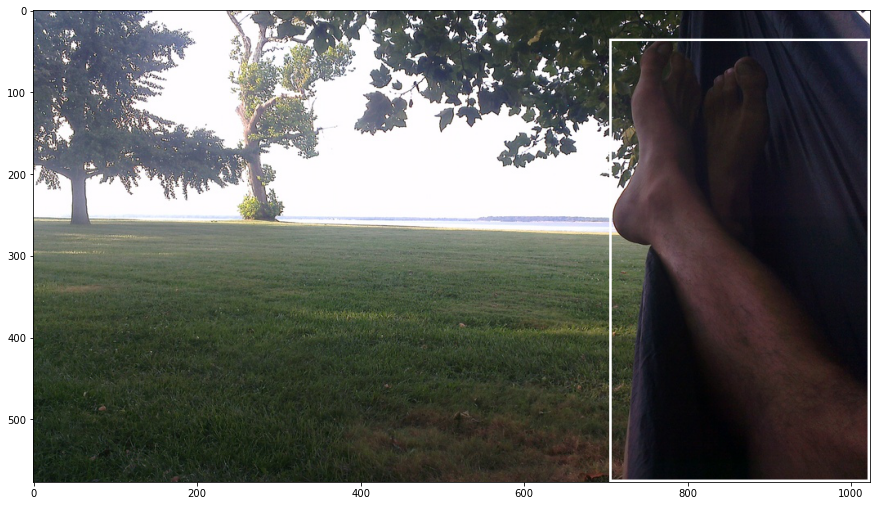

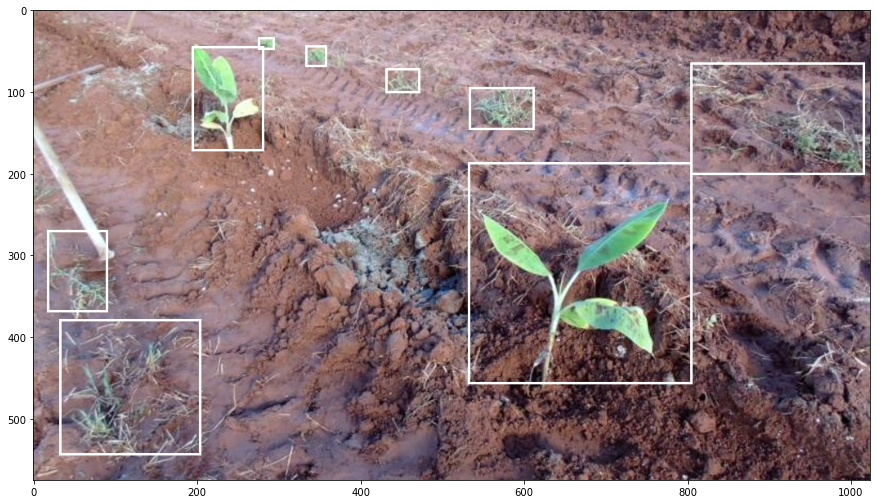

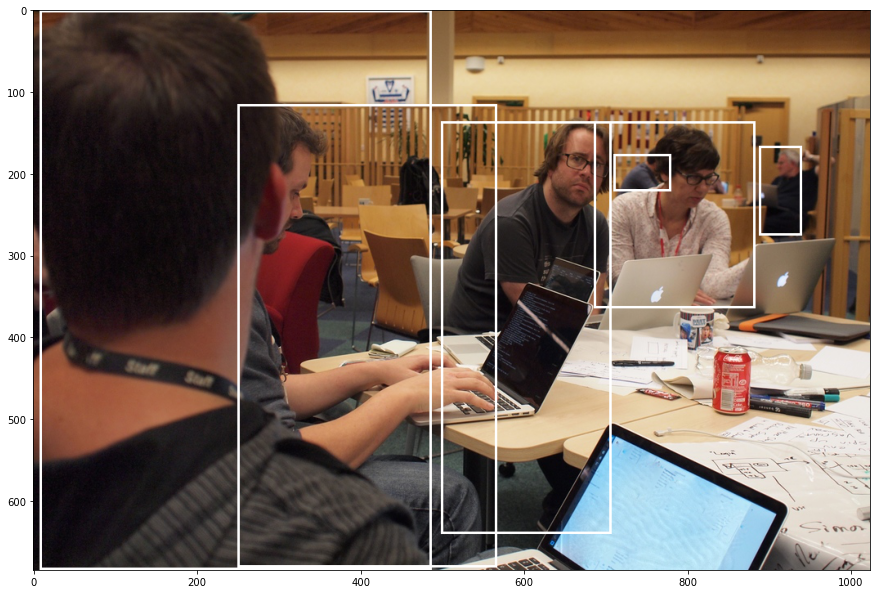

In [ ]:
def show_images(images, num = 5):
    
    images_to_show = np.random.choice(images, num)

    for image_id in images_to_show:

        image = Image.open(f'../input/object-det/train_repaired/train/{image_id}.jpg')

        w, h = image.size

#         print(w, h)

        bboxes = train_df[train_df['ImageID'] == image_id][['XMin','XMax','YMin','YMax']].to_numpy()

        # visualize them
        draw = ImageDraw.Draw(image)
        for bbox in bboxes:    
            draw.rectangle([bbox[0]*w, bbox[2]*h, bbox[1]*w, bbox[3]*h], width=3)

        plt.figure(figsize = (15,15))
        plt.imshow(image)
        plt.show()

show_images(train_df['ImageID'].unique(), num = 3)

### Read Training images

The objde dataset is in custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. User should write such a function when using a dataset in custom format. Given below is the function to do the same.

In [ ]:
dict_dataset = []
def get_dataset_dics(img_dir):
    for i in tqdm(train_df.groupby('ImageID')):

        image = Image.open(f'../input/object-det/train_repaired/train/{i[0]}.jpg')
        w, h = image.size
        
        ann_lst = []

        bboxes = i[1][['XMin','XMax','YMin','YMax']].to_numpy()
        # print(i[1].columns)
        for n, bbox in enumerate(bboxes):   
            xmin, xmax = int(bbox[0]*w), int(bbox[1]*w)
            ymin, ymax = int(bbox[2]*h), int(bbox[3]*h)
            poly = [
                (xmin, ymin), (xmax, ymin),
                (xmax, ymax), (xmin, ymax)
            ]
            
            poly = list(itertools.chain.from_iterable(poly))
            
            ann_dict = {
                'bbox': [xmin, ymin, xmax, ymax],
                'bbox_mode': BoxMode.XYXY_ABS,
                'category_id': i[1]['category_id'].values[0],
                'segmentation': [poly],
                'iscrowd': 0
            }
            
            ann_lst.append(ann_dict)

        image_dict = {'annotations': ann_lst,
            'file_name': '../input/object-det/train_repaired/train/'+i[0]+'.jpg',
            'height': h,
            'image_id': i[1]['image_category_id'].values[0],
            'width': w}
          
        dict_dataset.append(image_dict)
#         print(poly, dict_dataset)
#         break

    return dict_dataset

dict_dataset = get_dataset_dics(train_df['ImageID'])

### Read validation images

Prepare validation dataset into detectron2's standard format as well

In [ ]:
val_dict_dataset = []
def val_get_dataset_dics(img_dir):
    for i in tqdm(val_df.groupby('ImageID')):

        image = Image.open(f'../input/object-det/val/validation/{i[0]}.jpg')
        w, h = image.size
        
        ann_lst = []

        bboxes = i[1][['XMin','XMax','YMin','YMax']].to_numpy()
        # print(i[1].columns)
        for n, bbox in enumerate(bboxes):   
            xmin, xmax = int(bbox[0]*w), int(bbox[1]*w)
            ymin, ymax = int(bbox[2]*h), int(bbox[3]*h)
            poly = [
                (xmin, ymin), (xmax, ymin),
                (xmax, ymax), (xmin, ymax)
            ]
            
            poly = list(itertools.chain.from_iterable(poly))
            
            ann_dict = {
                'bbox': [xmin, ymin, xmax, ymax],
                'bbox_mode': BoxMode.XYXY_ABS,
                'category_id': i[1]['category_id'].values[0],
                'segmentation': [poly],
                'iscrowd': 0
            }
            
            ann_lst.append(ann_dict)

        image_dict = {'annotations': ann_lst,
            'file_name': '../input/object-det/val/validation/'+i[0]+'.jpg',
            'height': h,
            'image_id': i[1]['image_category_id'].values[0],
            'width': w}
          
        val_dict_dataset.append(image_dict)

    return val_dict_dataset

val_dict_dataset = val_get_dataset_dics(val_df['ImageID'])

### Data Augmentation

The dataset is transformed by resizing and cropping, changing the brighness and flipping the image with 50% probability.

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T

def custom_mapper(dataset_dict):
    
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [T.Resize((800,800)),
                      T.RandomBrightness(0.9, 1.1),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                      T.RandomCrop("absolute", (640, 640))
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict
class AugTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

### Register Dataset

Register our custom data with Detectron2 so it can be invoked for training.

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog

d = f"obj_train{np.random.randint(10000)}"
DatasetCatalog.register(d, lambda d=d : get_dataset_dics(train_df['ImageID']))
MetadataCatalog.get(d).set(thing_classes=["Person", "Clothing", "Car", "Plant", "Footwear"])
obj_metadata = MetadataCatalog.get(d)

In [ ]:
vv = f"obj_train{np.random.randint(10000)}"
DatasetCatalog.register(vv, lambda vv=vv : val_get_dataset_dics(train_df['ImageID']))
MetadataCatalog.get(vv).set(thing_classes=["Person", "Clothing", "Car", "Plant", "Footwear"])
val_obj_metadata = MetadataCatalog.get(vv)

Data registeration successful

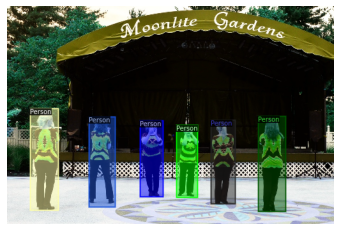

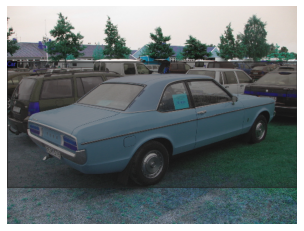

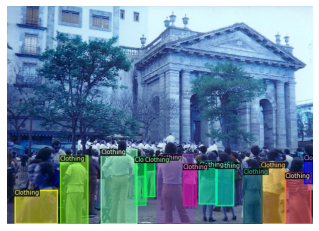

In [ ]:
for i in random.sample(dict_dataset, 3):
    img = cv2.imread(i["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=obj_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(i)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

### TRAIN

We use MaskRCNN with ResNet-50-C4 as backbone. It is pretrained on Pascal VOC 2012 dataset. It has similar data given as is in the given dataset and looks like a perfect fit. The boxAP for this model is 51.3 and has performed better than the remaining models. The model is trained for 1500 iterations with evaluation at every 500 itrerations.

You can read further about [here](https://research.fb.com/wp-content/uploads/2017/08/maskrcnn.pdf).

Other pre-trained models are available at https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("PascalVOC-Detection/faster_rcnn_R_50_C4.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("PascalVOC-Detection/faster_rcnn_R_50_C4.yaml")
cfg.DATASETS.TRAIN = (d,)
cfg.DATASETS.TEST = (vv, )
cfg.DATALOADER.NUM_WORKERS = 4

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5
cfg.TEST.EVAL_PERIOD = 500
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

### Training using custom trainer defined above

In [ ]:
trainer = AugTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

### Predictor

A predictor is defined with 0.5 threshold score which gives bounding box and label for the test images

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

The predictor returns bounding box in the order [XMin, YMin, XMax, YMax] along with the label of an image. The bounding box is normalised between 0 and 1.

In [ ]:
test_imgs_paths = sorted(os.listdir("../input/object-det/test/test"))

full_predictions = {"ImageID":[], "XMin":[], "XMax":[], "YMin":[], "YMax":[], "score":[], "LabelName":[]}

reverse_category_dict = {0:"Person", 1:"Clothing", 2:"Car", 3:"Plant", 4:"Footwear"}

cnt = 0
for test_img_path in tqdm(test_imgs_paths):
    
    img = cv2.imread(f"../input/object-det/test/test/{test_img_path}")
    h, w, _ = img.shape

    predictions = predictor(img)

    bboxes = predictions['instances'].pred_boxes.tensor.cpu().numpy()
    new_boxes = []
    for b in bboxes:
         new_boxes.append([b[0]/w, b[2]/w, b[1]/h, b[3]/h])

    new_boxes = np.array(new_boxes)
    if new_boxes.shape[0] > 0:

        classes = predictions['instances'].pred_classes.cpu().numpy()
        scores = predictions['instances'].scores.cpu().numpy()
        image_id = [test_img_path.split('.')[0]]*scores.shape[0]

        classes = [reverse_category_dict[i] for i in classes]
        full_predictions['ImageID'].extend(image_id)
        full_predictions['XMin'].extend(new_boxes[:,0])
        full_predictions['XMax'].extend(new_boxes[:,1])
        full_predictions['YMin'].extend(new_boxes[:,2])
        full_predictions['YMax'].extend(new_boxes[:,3])
        full_predictions['score'].extend(scores)
        full_predictions['LabelName'].extend(classes)

# Eval Metrics
Since this is a localization + classification problem, the evaluation metrics are different. Thus we use the concept of Intersection over Union. It computes the union of the 2 bounding boxes: the ground truth and the predicted bounding box.

We set threshold to see if a given box is valid or not. So if IoU>0.5, its a Tru
e Positive else its False Positive. If theres no prediction then a False Negativ
e. We compute Precision and Recall over all objects over all images to get mAP or mean Average Precision. In our case, the boxAP for our pretrained model is 51.9

Read more [here](https://towardsdatascience.com/evaluating-performance-of-an-object-detection-model-137a349c517b)

### Submission

In [ ]:
submissions = pd.DataFrame(full_predictions)

In [ ]:
submissions.to_csv("submission.csv", index=False)